#**0 LIBRARIES**

In [2]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 2.5 MB/s eta 0:00:00


In [86]:
from pyspark.sql import SparkSession
import os
import patoolib
import pandas as pd
import matplotlib.pyplot as plt
import glob
from functools import reduce
from pyspark.sql.functions import (
    col, trim, lower, sum, when, format_number, to_timestamp,
    row_number, split, regexp_extract, array, trim, explode, desc,
    to_date, month, year, weekofyear, dayofweek, udf
)
from pyspark.sql.types import StringType
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

#**1 STARTING SPARK SESSION**

In [4]:
spark = SparkSession.builder \
    .appName('Consulting Labs') \
    .getOrCreate()

#**2 LOADING DATA**

In [5]:
meta = pd.read_excel('/content/Metadata.xlsx')
meta.to_csv('/content/Metadata.csv', index = False)
meta = spark.read.csv('/content/Metadata.csv', header = True, inferSchema = True)

In [6]:
meta.show(truncate = False)
# truncate doesn't shrink long text

+---------------------+---------------------------------------+-----------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Unnamed: 0           |رقم التسجيل Visit Number               |تاريخ الزيارة                                                                      |نتائج  Results                                                                                                                                                                                                             

In [7]:
# extract compressed .rar files
patoolib.extract_archive('/content/Consulting Labs x HTU.rar', outdir = '/content/extracted')

INFO patool: Extracting /content/Consulting Labs x HTU.rar ...
INFO:patool:Extracting /content/Consulting Labs x HTU.rar ...
INFO patool: ... creating output directory `/content/extracted'.
INFO:patool:... creating output directory `/content/extracted'.
INFO patool: running /usr/bin/unrar x -kb -or -- "/content/Consulting Labs x HTU.rar"
INFO:patool:running /usr/bin/unrar x -kb -or -- "/content/Consulting Labs x HTU.rar"
INFO patool: ... /content/Consulting Labs x HTU.rar extracted to `/content/extracted'.
INFO:patool:... /content/Consulting Labs x HTU.rar extracted to `/content/extracted'.


'/content/extracted'

In [8]:
files = os.listdir('/content/extracted')
print(files)

['Consulting Labs x HTU']


In [9]:
excel_files = glob.glob('/content/extracted/Consulting Labs x HTU/*.xlsx')
print(excel_files)

['/content/extracted/Consulting Labs x HTU/3) Oct-Dec 2022 - unlock.xlsx', '/content/extracted/Consulting Labs x HTU/9)Jan-March-2024 unlock.xlsx', '/content/extracted/Consulting Labs x HTU/13)Jan-April-2025 unlock.xlsx', '/content/extracted/Consulting Labs x HTU/1) Jan-June 2022-unlock.xlsx', '/content/extracted/Consulting Labs x HTU/5) April-June-2023 - unlock.xlsx', '/content/extracted/Consulting Labs x HTU/7) Aug-Sep-2023 unlock.xlsx', '/content/extracted/Consulting Labs x HTU/2 July-Sep 2022-unlock.xlsx', '/content/extracted/Consulting Labs x HTU/10) April-June-2024 unlock.xlsx', '/content/extracted/Consulting Labs x HTU/4 Jan-March 2023-unlock.xlsx', '/content/extracted/Consulting Labs x HTU/12) Oct-Dec-2024 unlock.xlsx', '/content/extracted/Consulting Labs x HTU/6) July-2023 unlock.xlsx', '/content/extracted/Consulting Labs x HTU/8) Oct-Dec-2023 unlock.xlsx', '/content/extracted/Consulting Labs x HTU/11) July-Sep-2024 unlock.xlsx']


In [10]:
files = [pd.read_excel(f) for f in excel_files]
data = pd.concat(files, ignore_index = True)

#**3 READING DATA**

In [11]:
# beginning spark session
spark = SparkSession.builder.getOrCreate()
df = spark.createDataFrame(data)

In [12]:
# see some rows
df.show()

+----------+-----------+----------+----------+----------+----------+----------+--------------------+----------+----------+-----------+-----------+--------------------+-------+
|Unnamed: 0|رقم التسجيل|Unnamed: 2|Unnamed: 3|Unnamed: 4|Unnamed: 5|Unnamed: 6|       تاريخ الزيارة|Unnamed: 8|Unnamed: 9|Unnamed: 10|Unnamed: 11|               نتائج|تعليقات|
+----------+-----------+----------+----------+----------+----------+----------+--------------------+----------+----------+-----------+-----------+--------------------+-------+
|       NaN|        NaN|       NaN|       NaN|       NaN|       NaN|       NaN|                 NaN|       NaN|       NaN|        NaN|        NaN|                 NaN|    NaN|
|       NaN|  2202880.0|       NaN|       NaN|       NaN|       NaN|       NaN| 2022-10-01 08:30:40|       NaN|       NaN|        NaN|        NaN|                 NaN|    NaN|
|       NaN|  2202880.0|       NaN|       NaN|       NaN|       NaN|       NaN|Rheumatoid Factor...|       NaN|       Na

In [13]:
# checking columns
df.printSchema()

root
 |-- Unnamed: 0: double (nullable = true)
 |-- رقم التسجيل: double (nullable = true)
 |-- Unnamed: 2: double (nullable = true)
 |-- Unnamed: 3: double (nullable = true)
 |-- Unnamed: 4: double (nullable = true)
 |-- Unnamed: 5: double (nullable = true)
 |-- Unnamed: 6: double (nullable = true)
 |-- تاريخ الزيارة: string (nullable = true)
 |-- Unnamed: 8: double (nullable = true)
 |-- Unnamed: 9: double (nullable = true)
 |-- Unnamed: 10: double (nullable = true)
 |-- Unnamed: 11: double (nullable = true)
 |-- نتائج: string (nullable = true)
 |-- تعليقات: string (nullable = true)



In [14]:
df.columns

['Unnamed: 0',
 'رقم التسجيل',
 'Unnamed: 2',
 'Unnamed: 3',
 'Unnamed: 4',
 'Unnamed: 5',
 'Unnamed: 6',
 'تاريخ الزيارة',
 'Unnamed: 8',
 'Unnamed: 9',
 'Unnamed: 10',
 'Unnamed: 11',
 'نتائج',
 'تعليقات']

#**4 CLEANING DATA**

**Dropping nulls**

In [16]:
# viewing nulls in cols
df.select([
    sum(
        when(
            col(c).isNull() |
            (trim(col(c).cast('string')) == '') |
            (lower(trim(col(c).cast('string'))).isin('nan', 'none')), 1
        ).otherwise(0)).alias(c)for c in df.columns]).show()

+----------+-----------+----------+----------+----------+----------+----------+-------------+----------+----------+-----------+-----------+------+-------+
|Unnamed: 0|رقم التسجيل|Unnamed: 2|Unnamed: 3|Unnamed: 4|Unnamed: 5|Unnamed: 6|تاريخ الزيارة|Unnamed: 8|Unnamed: 9|Unnamed: 10|Unnamed: 11| نتائج|تعليقات|
+----------+-----------+----------+----------+----------+----------+----------+-------------+----------+----------+-----------+-----------+------+-------+
|    362628|      81191|    362628|    362628|    362628|    362628|    362628|        81193|    362628|    362628|     362628|     362628|163718| 362473|
+----------+-----------+----------+----------+----------+----------+----------+-------------+----------+----------+-----------+-----------+------+-------+



In [17]:
# num. of rows in df
df.count()

362628

In [18]:
# drop useless cols
df = df.drop('Unnamed: 0',
             'Unnamed: 2',
             'Unnamed: 3',
             'Unnamed: 4',
             'Unnamed: 5',
             'Unnamed: 6',
             'Unnamed: 8',
             'Unnamed: 9',
             'Unnamed: 10',
             'Unnamed: 11')
df.columns

['رقم التسجيل', 'تاريخ الزيارة', 'نتائج', 'تعليقات']

In [19]:
# changing to english col names (easier to handle)
df = df.withColumnRenamed('تعليقات', 'comments') \
        .withColumnRenamed('نتائج', 'results') \
        .withColumnRenamed('تاريخ الزيارة', 'visit_date') \
        .withColumnRenamed('رقم التسجيل', 'regist_id')
df.columns

['regist_id', 'visit_date', 'results', 'comments']

In [20]:
# seeing nulls again
df.select([
    sum(
        when(
            col(c).isNull() |
            (trim(col(c).cast('string')) == '') |
            (lower(trim(col(c).cast('string'))).isin('nan', 'none')), 1
        ).otherwise(0)).alias(c)for c in df.columns]).show()

+---------+----------+-------+--------+
|regist_id|visit_date|results|comments|
+---------+----------+-------+--------+
|    81191|     81193| 163718|  362473|
+---------+----------+-------+--------+



In [21]:
df.show(5)

+---------+--------------------+--------------------+--------+
|regist_id|          visit_date|             results|comments|
+---------+--------------------+--------------------+--------+
|      NaN|                 NaN|                 NaN|     NaN|
|2202880.0| 2022-10-01 08:30:40|                 NaN|     NaN|
|2202880.0|Rheumatoid Factor...|Rheumatoid Factor...|     NaN|
|2202880.0|                 ESR|         ESR: 54 mm.|     NaN|
|2202880.0|          Uric Acid |Uric Acid: 188 um...|     NaN|
+---------+--------------------+--------------------+--------+
only showing top 5 rows



In [23]:
# removing rows that are fully null, nan, & none
df = df.filter(
    ~(
        reduce(
            lambda a, b: a & b,
             [
                 (col(c).isNull() |
                  (trim(col(c).cast("string")) == "") |
                 (lower(trim(col(c).cast("string"))).isin("nan", "none")))
                for c in df.columns
            ])))

In [24]:
# seeing nulls again
df.select([
    sum(
        when(
            col(c).isNull() |
            (trim(col(c).cast('string')) == '') |
            (lower(trim(col(c).cast('string'))).isin('nan', 'none')), 1
        ).otherwise(0)).alias(c)for c in df.columns]).show()

+---------+----------+-------+--------+
|regist_id|visit_date|results|comments|
+---------+----------+-------+--------+
|        0|         2|  82527|  281282|
+---------+----------+-------+--------+



In [25]:
df.count()

281437

In [26]:
# dropping duplicates
df = df.dropDuplicates()

In [27]:
df.count()

281436

In [28]:
# checking registration id format
df.select('regist_id').show(truncate = False)

+-----------+
|regist_id  |
+-----------+
|2.2013818E7|
|2202885.0  |
|2202898.0  |
|2.2013897E7|
|2205827.0  |
|2.2013914E7|
|2205839.0  |
|2205852.0  |
|2205866.0  |
|2.2013979E7|
|2.201399E7 |
|2205874.0  |
|2.2014033E7|
|2.2014042E7|
|2202981.0  |
|2206200.0  |
|2.2014119E7|
|2.201423E7 |
|2.2021075E7|
|2.2014309E7|
+-----------+
only showing top 20 rows



In [30]:
# reverting registration id back to its orginal form - no decimals
df = df.withColumn('regist_id', col('regist_id').cast('long').cast('string'))
df.select('regist_id').show(truncate = False)

+---------+
|regist_id|
+---------+
|22013818 |
|2202885  |
|2202898  |
|22013897 |
|2205827  |
|22013914 |
|2205839  |
|2205852  |
|2205866  |
|22013979 |
|22013990 |
|2205874  |
|22014033 |
|22014042 |
|2202981  |
|2206200  |
|22014119 |
|22014230 |
|22021075 |
|22014309 |
+---------+
only showing top 20 rows



In [31]:
df.columns

['regist_id', 'visit_date', 'results', 'comments']

In [32]:
df.select('regist_id', 'visit_date', 'results').show(truncate = False)

+---------+--------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|regist_id|visit_date                |results                                                                                                                                                                                                                                                                                                                         |
+---------+--------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [34]:
# converting visit data from string to datetime
df = df.withColumn('timestamp', to_timestamp('visit_date', 'yyyy-MM-dd HH:mm:ss'))
df.select('visit_date', 'timestamp').show(truncate = False)

+--------------------------+-------------------+
|visit_date                |timestamp          |
+--------------------------+-------------------+
|2022-10-01 10:13:30       |2022-10-01 10:13:30|
|2022-10-01 10:58:36       |2022-10-01 10:58:36|
|2022-10-02 09:24:39       |2022-10-02 09:24:39|
|2022-10-02 12:15:57       |2022-10-02 12:15:57|
|2022-10-02 12:34:44       |2022-10-02 12:34:44|
|Complete Blood Count (CBC)|NULL               |
|Ferritin                  |NULL               |
|Urea                      |NULL               |
|SGOT (AST)                |NULL               |
|Culture                   |NULL               |
|Bilirubin Total (BILT)    |NULL               |
|2022-10-04 13:36:31       |2022-10-04 13:36:31|
|2022-10-06 09:08:24       |2022-10-06 09:08:24|
|Antinuclear Antibody ANA  |NULL               |
|Ferritin                  |NULL               |
|Ferritin                  |NULL               |
|2022-10-08 16:51:15       |2022-10-08 16:51:15|
|Ferritin           

In [35]:
# visit date has more than JUST visit dates
# to clean, extract date into a column alone
df = df.withColumn('timestamp', to_timestamp('visit_date', 'yyyy-MM-dd HH:mm:ss'))
df.select('regist_id', 'visit_date', 'timestamp').show(truncate = False)

+---------+--------------------------+-------------------+
|regist_id|visit_date                |timestamp          |
+---------+--------------------------+-------------------+
|22013818 |2022-10-01 10:13:30       |2022-10-01 10:13:30|
|2202885  |2022-10-01 10:58:36       |2022-10-01 10:58:36|
|2202898  |2022-10-02 09:24:39       |2022-10-02 09:24:39|
|22013897 |2022-10-02 12:15:57       |2022-10-02 12:15:57|
|2205827  |2022-10-02 12:34:44       |2022-10-02 12:34:44|
|22013914 |Complete Blood Count (CBC)|NULL               |
|2205839  |Ferritin                  |NULL               |
|2205852  |Urea                      |NULL               |
|2205866  |SGOT (AST)                |NULL               |
|22013979 |Culture                   |NULL               |
|22013990 |Bilirubin Total (BILT)    |NULL               |
|2205874  |2022-10-04 13:36:31       |2022-10-04 13:36:31|
|22014033 |2022-10-06 09:08:24       |2022-10-06 09:08:24|
|22014042 |Antinuclear Antibody ANA  |NULL              

In [36]:
df.printSchema()

root
 |-- regist_id: string (nullable = true)
 |-- visit_date: string (nullable = true)
 |-- results: string (nullable = true)
 |-- comments: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [37]:
# cleaing time columns
df = df.withColumn('requested_tests',
                   when(col('timestamp').isNull(), col('visit_date')))\
       .withColumn('visit_date',
                   when(col('timestamp').isNotNull(), col('timestamp')))\
       .drop('timestamp')

In [38]:
df.columns

['regist_id', 'visit_date', 'results', 'comments', 'requested_tests']

In [39]:
# reordering columns for better look
df = df.select('regist_id', 'visit_date', 'requested_tests', 'results', 'comments')
df.columns

['regist_id', 'visit_date', 'requested_tests', 'results', 'comments']

In [40]:
# making name shorter (easier to handle)
df = df.withColumnRenamed('requested_tests', 'req_tests')
df.columns

['regist_id', 'visit_date', 'req_tests', 'results', 'comments']

In [41]:
df.select('regist_id', 'visit_date', 'req_tests', 'results').show(truncate = False)

+---------+-------------------+--------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|regist_id|visit_date         |req_tests                 |results                                                                                                                                                                                                                                                                                                                         |
+---------+-------------------+--------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
# looking for non null visit dates
visit_dates = df.filter(col('visit_date').isNotNull()) \
                .select('regist_id', 'visit_date') \
                .dropDuplicates()

In [43]:
visit_dates.count()

81191

In [44]:
visit_dates.show()

+---------+-------------------+
|regist_id|         visit_date|
+---------+-------------------+
| 25051364|2025-02-02 12:33:46|
| 23054781|2023-05-25 16:00:22|
| 23021507|2023-05-02 11:27:41|
| 23055639|2023-06-11 18:59:23|
| 22012482|2022-08-23 12:38:35|
| 23053981|2023-05-08 16:27:56|
| 24051470|2024-02-04 11:49:46|
|  2406215|2024-02-06 10:56:58|
| 24053034|2024-03-07 17:48:50|
| 23016569|2023-09-19 10:21:21|
|  2201892|2022-07-14 09:17:38|
|230511138|2023-09-28 10:46:27|
| 25051351|2025-02-02 11:19:19|
| 22051331|2022-11-05 13:26:29|
| 25051177|2025-01-28 13:37:01|
| 23013088|2023-05-06 08:22:47|
| 22011437|2022-07-27 10:55:18|
|  2205159|2022-08-14 13:35:42|
| 23061525|2023-08-23 09:25:40|
| 23053141|2023-04-17 21:15:29|
+---------+-------------------+
only showing top 20 rows



In [45]:
# some dates are missing but can be found from regist id
# fill missing dates based on id
df = df.join(visit_dates.withColumnRenamed('visit_date', 'fixed_date'),
             on = 'regist_id', how = 'left') \
       .withColumn('visit_date',
                   when(col('visit_date').isNull(), col('fixed_date'))
                   .otherwise(col('visit_date'))) \
       .drop('fixed_date')

In [46]:
df.show()

+---------+-------------------+--------------------+--------------------+--------+
|regist_id|         visit_date|           req_tests|             results|comments|
+---------+-------------------+--------------------+--------------------+--------+
|  2205866|2022-10-04 11:44:27|          SGOT (AST)| SGOT (AST): 14 IU/L|     NaN|
| 22021075|2022-10-13 11:58:25|                NULL|                 NaN|     NaN|
|  2205839|2022-10-03 09:51:02|            Ferritin|  Ferritin: 32 ng/ml|     NaN|
| 22014119|2022-10-08 16:51:15|                NULL|                 NaN|     NaN|
|  2205827|2022-10-02 12:34:44|                NULL|                 NaN|     NaN|
|  2206200|2022-10-06 17:31:08|            Ferritin|  Ferritin: 95 ng/ml|     NaN|
|  2205852|2022-10-03 15:53:02|               Urea |Urea (URS): 4.8 m...|     NaN|
|  2205874|2022-10-04 13:36:31|                NULL|                 NaN|     NaN|
| 22014309|2022-10-15 11:31:16|      Urine Analysis|Colour: Yellow , ...|     NaN|
| 22

In [47]:
df.count()

281436

In [48]:
# check nulls
df.select([
    sum(
        when(
            col(c).isNull() |
            (trim(col(c).cast('string')) == '') |
            (lower(trim(col(c).cast('string'))).isin('nan', 'none')), 1
        ).otherwise(0)).alias(c)for c in df.columns]).show()

+---------+----------+---------+-------+--------+
|regist_id|visit_date|req_tests|results|comments|
+---------+----------+---------+-------+--------+
|        0|         0|    81193|  82526|  281281|
+---------+----------+---------+-------+--------+



In [49]:
df.orderBy(['regist_id', 'visit_date']).show(truncate = False)

+---------+-------------------+-------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [50]:
# filter rows with req tests but no results
no_result = df.filter(
    (col('req_tests').isNotNull()) &
    (col('results').isNull() |
        (trim(col('results')) == '') |
        (lower(trim(col('results'))).isin('none', 'nan'))
    )
)

In [51]:
no_result.count()

1335

In [52]:
no_result.show(truncate = False)

+---------+-------------------+----------------------------------+-------+--------+
|regist_id|visit_date         |req_tests                         |results|comments|
+---------+-------------------+----------------------------------+-------+--------+
|23054017 |2023-05-09 12:32:28|Serum Protein Electrophoresis     |NaN    |NaN     |
|22051401 |2022-11-09 11:41:05|Complete Blood Count (CBC)        |NaN    |NaN     |
|25054231 |2025-04-20 14:05:00|Glycosylated Hemoglobin (HbA1c)   |NaN    |NaN     |
|22052075 |2022-12-20 14:04:31|Blood Group                       |NaN    |NaN     |
|25053710 |2025-04-09 11:50:07|Histopathology                    |NaN    |NaN     |
|2405268  |2024-01-07 10:33:11|Bicarbonate                       |NaN    |NaN     |
|25053909 |2025-04-14 11:12:58|Histopathology                    |NaN    |NaN     |
|25053359 |2025-04-03 12:13:03|Total Cholesterol                 |NaN    |NaN     |
|23054356 |2023-05-16 14:26:06|Chromosomal Karyotyping (Blood)   |NaN    |Na

In [53]:
# filter rows with results but no req. test
no_req = df.filter(
    (col('req_tests').isNull() |
      (trim(col('req_tests')) == '') |
      (lower(trim(col('req_tests'))).isin('none', 'nan'))
    ) &
    (col('results').isNotNull())
)

In [54]:
no_req.count()

81193

In [55]:
no_req.show(truncate = False)

+---------+-------------------+---------+-------+--------+
|regist_id|visit_date         |req_tests|results|comments|
+---------+-------------------+---------+-------+--------+
|22015104 |2022-11-09 12:26:23|NULL     |NaN    |NaN     |
|22014972 |2022-11-05 14:44:50|NULL     |NaN    |NaN     |
|22021205 |2022-10-24 11:21:56|NULL     |NaN    |NaN     |
|22021075 |2022-10-13 11:58:25|NULL     |NaN    |NaN     |
|22014119 |2022-10-08 16:51:15|NULL     |NaN    |NaN     |
|2205827  |2022-10-02 12:34:44|NULL     |NaN    |NaN     |
|22051192 |2022-10-29 10:40:50|NULL     |NaN    |NaN     |
|22021198 |2022-10-24 10:05:51|NULL     |NaN    |NaN     |
|22051286 |2022-11-02 12:13:31|NULL     |NaN    |NaN     |
|22014479 |2022-10-20 14:32:43|NULL     |NaN    |NaN     |
|2205874  |2022-10-04 13:36:31|NULL     |NaN    |NaN     |
|22014033 |2022-10-06 09:08:24|NULL     |NaN    |NaN     |
|22014800 |2022-10-31 09:40:22|NULL     |NaN    |NaN     |
|22013818 |2022-10-01 10:13:30|NULL     |NaN    |NaN    

In [56]:
# filter rows with no req tests or results
no_reqresult = df.filter(
    (
        col('results').isNull() |
        (trim(col('results')) == '') |
        (lower(trim(col('results'))).isin('none', 'nan'))
    ) &
    (
        col('req_tests').isNull() |
        (trim(col('req_tests')) == '') |
        (lower(trim(col('req_tests'))).isin('none', 'nan'))
    )
)

In [57]:
no_reqresult.count()

81191

In [58]:
no_reqresult.show(truncate = False)

+---------+-------------------+---------+-------+--------+
|regist_id|visit_date         |req_tests|results|comments|
+---------+-------------------+---------+-------+--------+
|22015104 |2022-11-09 12:26:23|NULL     |NaN    |NaN     |
|22014972 |2022-11-05 14:44:50|NULL     |NaN    |NaN     |
|22021205 |2022-10-24 11:21:56|NULL     |NaN    |NaN     |
|22021075 |2022-10-13 11:58:25|NULL     |NaN    |NaN     |
|22014119 |2022-10-08 16:51:15|NULL     |NaN    |NaN     |
|2205827  |2022-10-02 12:34:44|NULL     |NaN    |NaN     |
|22051192 |2022-10-29 10:40:50|NULL     |NaN    |NaN     |
|22021198 |2022-10-24 10:05:51|NULL     |NaN    |NaN     |
|22051286 |2022-11-02 12:13:31|NULL     |NaN    |NaN     |
|22014479 |2022-10-20 14:32:43|NULL     |NaN    |NaN     |
|2205874  |2022-10-04 13:36:31|NULL     |NaN    |NaN     |
|22014033 |2022-10-06 09:08:24|NULL     |NaN    |NaN     |
|22014800 |2022-10-31 09:40:22|NULL     |NaN    |NaN     |
|22013818 |2022-10-01 10:13:30|NULL     |NaN    |NaN    

In [59]:
# diff. between no_req and no_reqresult is just 2 rows: find them
diff = no_req.subtract(no_reqresult)
diff.show(truncate = False)

+---------+-------------------+---------+------------------------------+--------+
|regist_id|visit_date         |req_tests|results                       |comments|
+---------+-------------------+---------+------------------------------+--------+
|230510352|2023-09-12 13:12:28|NaN      |:  Malik AL Hossein AL Omari  |NaN     |
|23016547 |2023-09-18 10:22:58|NaN      |: Fatema Akte Lili Abul Kal   |NaN     |
+---------+-------------------+---------+------------------------------+--------+



In [60]:
# results make no sense - drop the 2 rows.
df = df.subtract(diff)

In [61]:
# refilter no requested test again
no_req = df.filter(
    (col('req_tests').isNull() |
      (trim(col('req_tests')) == '') |
      (lower(trim(col('req_tests'))).isin('none', 'nan'))
    ) &
    (col('results').isNotNull())
)

In [62]:
no_req.count()

81191

In [63]:
# refilter no req tests or result again
no_reqresult = df.filter(
    (
        col('results').isNull() |
        (trim(col('results')) == '') |
        (lower(trim(col('results'))).isin('none', 'nan'))
    ) &
    (
        col('req_tests').isNull() |
        (trim(col('req_tests')) == '') |
        (lower(trim(col('req_tests'))).isin('none', 'nan'))
    )
)

In [64]:
no_reqresult.count()

81191

In [ ]:
# nulls for no test requested AND no test req + no result is equal
# if no tests is requested, there is no result

In [65]:
# if test is requested but result is missing, fill with 'pending'
df = df.withColumn(
    'results',
    when(
        (col('req_tests').isNotNull()) &
        (
            col('results').isNull() |
            (trim(col('results')) == '') |
            (lower(trim(col('results'))).isin('none', 'nan'))
        ),
        'pending'
    ).otherwise(col('results'))
)

In [66]:
# check if filling worked
no_result = df.filter(
    (col('req_tests').isNotNull()) &
    (col('results').isNull() |
        (trim(col('results')) == '') |
        (lower(trim(col('results'))).isin('none', 'nan'))
    )
)

In [67]:
no_result.count() # it did, no more nulls

0

In [68]:
# check how it looks
df.filter(col('results') == 'pending') \
  .select('regist_id', 'visit_date', 'req_tests', 'results') \
  .show(truncate = False)

+---------+-------------------+---------------------------------+-------+
|regist_id|visit_date         |req_tests                        |results|
+---------+-------------------+---------------------------------+-------+
|2206151  |2022-09-29 10:45:58|Vitamin B12                      |pending|
|23012845 |2023-04-26 16:06:08|Fasting Blood Sugar (FBS)        |pending|
|240513785|2024-10-29 13:22:40|Plates (Mix , MH , SDA ) 5       |pending|
|25053048 |2025-03-20 14:46:55|Histopathology                   |pending|
|2506398  |2025-03-27 11:38:19|B2-Transferrin                   |pending|
|23056536 |2023-07-05 13:15:42|Anti-Cardiolipin Antibody (IgG)  |pending|
|23057138 |2023-07-16 11:29:05|Blood film                       |pending|
|240514313|2024-11-10 15:38:55|Food RAST                        |pending|
|2305469  |2023-01-24 14:06:20|Total Protein , Serum            |pending|
|25052641 |2025-03-09 12:11:28|Histopathology                   |pending|
|25053430 |2025-04-05 12:36:15|Pap Sme

In [69]:
# if row has no req test and no result, fill with 'no test requested'
df = df.withColumn(
    'req_tests',
    when(
        (
            (col('req_tests').isNull()) |
            (trim(col('req_tests')) == '') |
            (lower(trim(col('req_tests'))).isin('none', 'nan'))
        ) &
        (
            (col('results').isNull()) |
            (trim(col('results')) == '') |
            (lower(trim(col('results'))).isin('none', 'nan'))
        ),
        'no test requested'
    ).otherwise(col('req_tests'))
)

In [70]:
# validate how it looks
df.filter(col('req_tests') == 'no test requested') \
  .select('regist_id', 'visit_date', 'req_tests', 'results') \
  .show(truncate = False)

+---------+-------------------+-----------------+-------+
|regist_id|visit_date         |req_tests        |results|
+---------+-------------------+-----------------+-------+
|24013727 |2024-08-03 10:55:54|no test requested|NaN    |
|24057029 |2024-06-03 08:19:32|no test requested|NaN    |
|2501814  |2025-02-22 13:55:37|no test requested|NaN    |
|2405321  |2024-01-07 18:33:08|no test requested|NaN    |
|24059502 |2024-07-24 13:12:55|no test requested|NaN    |
|230238   |2023-01-04 10:42:57|no test requested|NaN    |
|230511225|2023-09-30 15:11:13|no test requested|NaN    |
|22015535 |2022-11-24 11:36:14|no test requested|NaN    |
|23017283 |2023-10-22 13:38:56|no test requested|NaN    |
|23014439 |2023-06-25 08:14:42|no test requested|NaN    |
|230512930|2023-11-11 11:00:54|no test requested|NaN    |
|23052902 |2023-04-10 21:46:06|no test requested|NaN    |
|24059873 |2024-07-31 11:46:13|no test requested|NaN    |
|24015631 |2024-11-20 14:54:32|no test requested|NaN    |
|240513993|202

In [71]:
# now just fill the results col same way
df = df.withColumn(
    'results',
    when(
        (
            (col('results').isNull()) |
            (trim(col('results')) == '') |
            (lower(trim(col('results'))).isin('none', 'nan'))
        ) &
        (col('req_tests') == 'no test requested'),
        'no test requested'
    ).otherwise(col('results'))
)

In [72]:
# validating how it looks like
df.filter(col('results') == 'no test requested') \
  .select('regist_id', 'visit_date', 'req_tests', 'results') \
  .show(truncate = False)

+---------+-------------------+-----------------+-----------------+
|regist_id|visit_date         |req_tests        |results          |
+---------+-------------------+-----------------+-----------------+
|24013727 |2024-08-03 10:55:54|no test requested|no test requested|
|24057029 |2024-06-03 08:19:32|no test requested|no test requested|
|2501814  |2025-02-22 13:55:37|no test requested|no test requested|
|2405321  |2024-01-07 18:33:08|no test requested|no test requested|
|24059502 |2024-07-24 13:12:55|no test requested|no test requested|
|230238   |2023-01-04 10:42:57|no test requested|no test requested|
|230511225|2023-09-30 15:11:13|no test requested|no test requested|
|22015535 |2022-11-24 11:36:14|no test requested|no test requested|
|23017283 |2023-10-22 13:38:56|no test requested|no test requested|
|23014439 |2023-06-25 08:14:42|no test requested|no test requested|
|230512930|2023-11-11 11:00:54|no test requested|no test requested|
|23052902 |2023-04-10 21:46:06|no test requested

In [73]:
# refiltering
no_reqresult = df.filter(
    (
        col('results').isNull() |
        (trim(col('results')) == '') |
        (lower(trim(col('results'))).isin('none', 'nan'))
    ) &
    (
        col('req_tests').isNull() |
        (trim(col('req_tests')) == '') |
        (lower(trim(col('req_tests'))).isin('none', 'nan'))
    )
)

In [74]:
no_reqresult.count() # no more nulls

0

In [75]:
df.count()

281434

In [76]:
# checking nulls - only comments is null
df.select([
    sum(
        when(
            col(c).isNull() |
            (trim(col(c).cast('string')) == '') |
            (lower(trim(col(c).cast('string'))).isin('nan', 'none')), 1
        ).otherwise(0)).alias(c)for c in df.columns]).show()

+---------+----------+---------+-------+--------+
|regist_id|visit_date|req_tests|results|comments|
+---------+----------+---------+-------+--------+
|        0|         0|        0|      0|  281279|
+---------+----------+---------+-------+--------+



In [77]:
# results col has test name AND results
df.select('results').show(truncate = False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|results                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
+-----------

In [78]:
df.show(truncate = False)

+---------+-------------------+----------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|regist_id|visit_date         |req_tests                         |results                                                                                                                                                                                                                                                                                                                                                                       

In [79]:
df.show(200, truncate = False)

+---------+-------------------+----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------

In [80]:
df.groupBy('req_tests').count().orderBy('count', ascending = False).show(truncate = False)

+-------------------------------+-----+
|req_tests                      |count|
+-------------------------------+-----+
|no test requested              |81191|
|Complete Blood Count (CBC)     |16072|
|Ferritin                       |9611 |
|Thyroid Stimulating Hormone TSH|9571 |
|Vitamin B12                    |9364 |
|Glycosylated Hemoglobin (HbA1c)|8927 |
|Urine Analysis                 |8679 |
|Creatinine                     |6094 |
|Vitamin D3                     |5975 |
|Fasting Blood Sugar (FBS)      |5462 |
|Triglycerides                  |4567 |
|Total Cholesterol              |4553 |
|Urea                           |4501 |
|Culture                        |3449 |
|SGPT (ALT)                     |3355 |
|LDL - Cholesterol              |3292 |
|SGOT (AST)                     |3206 |
|Free T4 (FT4)                  |3198 |
|HDL -Cholesterol               |3114 |
|Uric Acid                      |3016 |
+-------------------------------+-----+
only showing top 20 rows



In [81]:
df.groupBy('req_tests') \
  .count() \
  .orderBy('count', ascending = False) \
  .show(truncate = False, n = 1000)

+------------------------------------------------+-----+
|req_tests                                       |count|
+------------------------------------------------+-----+
|no test requested                               |81191|
|Complete Blood Count (CBC)                      |16072|
|Ferritin                                        |9611 |
|Thyroid Stimulating Hormone TSH                 |9571 |
|Vitamin B12                                     |9364 |
|Glycosylated Hemoglobin (HbA1c)                 |8927 |
|Urine Analysis                                  |8679 |
|Creatinine                                      |6094 |
|Vitamin D3                                      |5975 |
|Fasting Blood Sugar (FBS)                       |5462 |
|Triglycerides                                   |4567 |
|Total Cholesterol                               |4553 |
|Urea                                            |4501 |
|Culture                                         |3449 |
|SGPT (ALT)                    

In [83]:
# define window to group by test name, ordered by patient ID
# window = subset of rows to aggregate them
window_spec = Window.partitionBy('req_tests').orderBy('regist_id')

In [ ]:
# add row numbers per test group, keeping only first row of each test
df_with_row = df.withColumn('row_num', row_number().over(window_spec))
df_unique_tests = df_with_row.filter('row_num = 1').drop('row_num')

In [87]:
# helps me visualize how each test's results look like to clean it
df_unique_tests.show(truncate = False, n = 1000)

+---------+-------------------+------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [88]:
# fn. to categorize results to clean them
def categorize_test(result_text):
  if result_text is None:
    return 'unknown'
  if any(sep in result_text for sep in [':', ' : ', '-', ' - ', '/', ' / ']):
    if ',' in result_text or '\n' in result_text or ' / ' in result_text:
      return 'panel' # has multiple results in one cell (many separators)
    return 'single' # just one separator so one results
  elif len(result_text.split()) > 20:
    return 'narrative' # long text or string, just talking basically
  return 'unknown' # anything else

In [89]:
# udf = user defined fn, using python fn's in spark
# wrap my fn basically and return string type
categorize_udf = udf(categorize_test, StringType())

In [90]:
# saving fn. result in new col called 'result_type'
df = df.withColumn('result_type', categorize_udf(col('results')))

In [91]:
df.groupBy('req_tests', 'result_type').count(
    ).orderBy('count', ascending = False).show(truncate = False, n = 1000)

+------------------------------------------------+-----------+-----+
|req_tests                                       |result_type|count|
+------------------------------------------------+-----------+-----+
|no test requested                               |unknown    |81191|
|Complete Blood Count (CBC)                      |panel      |16045|
|Ferritin                                        |single     |9593 |
|Thyroid Stimulating Hormone TSH                 |single     |9561 |
|Vitamin B12                                     |single     |9332 |
|Glycosylated Hemoglobin (HbA1c)                 |single     |8912 |
|Urine Analysis                                  |panel      |8676 |
|Creatinine                                      |panel      |6088 |
|Vitamin D3                                      |single     |5957 |
|Fasting Blood Sugar (FBS)                       |panel      |5451 |
|Triglycerides                                   |panel      |4557 |
|Total Cholesterol                

In [92]:
# df copy to not mess up og
df2 = df.select('*')

In [93]:
# split results into array by commas (panels), else (single) wrap result in array
df2 = df2.withColumn(
    'results',
    when(
        col('result_type') == 'panel',
        split(col('results'), ',\s*')
    ).otherwise(array(col('results')))
)

In [94]:
# flatten results array - each entry = own row (every other col is the same)
df2 = df2.withColumn('results', explode(col('results')))

In [188]:
# anything before the seperator = test_name (new col)
df2 = df2.withColumn(
    'test_name',
    regexp_extract(col('results'), r'^([^:]+):', 1)
)

In [96]:
# result has a colon, extract the part after it
df2 = df2.withColumn(
    'results',
    when(
        col('results').rlike(r':'),
        regexp_extract(col('results'), r'[^:]*: *(.*)', 1)
    ).otherwise(col('results'))
)

In [97]:
# worked!! but there's a test name called -- ??
df2.filter(col('result_type') == 'panel') \
   .select('regist_id', 'visit_date', 'req_tests', 'test_name', 'results') \
   .show(5, truncate = False)

+---------+-------------------+--------------------------+----------------+---------------+
|regist_id|visit_date         |req_tests                 |test_name       |results        |
+---------+-------------------+--------------------------+----------------+---------------+
|240512005|2024-09-16 12:54:56|Creatinine                |Creatinine (CRS)|45 umol/L      |
|240512005|2024-09-16 12:54:56|Creatinine                |--              |0.51 mg/dl     |
|23018368 |2023-12-20 11:22:28|Complete Blood Count (CBC)|Hemoglobin Level|10.7 g/dl      |
|23018368 |2023-12-20 11:22:28|Complete Blood Count (CBC)|Hematocrit      |33 %           |
|23018368 |2023-12-20 11:22:28|Complete Blood Count (CBC)|Red Cell Count  |4.3 millions/ul|
+---------+-------------------+--------------------------+----------------+---------------+
only showing top 5 rows



In [98]:
# removing rows where test name is dashes or empty (like the -- we found lol)
df2 = df2.filter(~col('test_name').rlike(r'^\s*--\s*$'))

In [99]:
# yay worked
df2.filter(col('result_type') == 'panel') \
   .select('regist_id', 'visit_date', 'req_tests', 'test_name', 'results') \
   .show(5, truncate = False)

+---------+-------------------+--------------------------+----------------+---------------+
|regist_id|visit_date         |req_tests                 |test_name       |results        |
+---------+-------------------+--------------------------+----------------+---------------+
|240512005|2024-09-16 12:54:56|Creatinine                |Creatinine (CRS)|45 umol/L      |
|23018368 |2023-12-20 11:22:28|Complete Blood Count (CBC)|Hemoglobin Level|10.7 g/dl      |
|23018368 |2023-12-20 11:22:28|Complete Blood Count (CBC)|Hematocrit      |33 %           |
|23018368 |2023-12-20 11:22:28|Complete Blood Count (CBC)|Red Cell Count  |4.3 millions/ul|
|23018368 |2023-12-20 11:22:28|Complete Blood Count (CBC)|MCV             |76.74 fl       |
+---------+-------------------+--------------------------+----------------+---------------+
only showing top 5 rows



In [100]:
# also worked yayy
df2.filter(col('result_type') == 'single') \
   .select('regist_id', 'visit_date', 'req_tests', 'test_name', 'results') \
   .show(5, truncate = False)

+---------+-------------------+----------------------------------+----------------------------------+-----------+
|regist_id|visit_date         |req_tests                         |test_name                         |results    |
+---------+-------------------+----------------------------------+----------------------------------+-----------+
|230513305|2023-11-22 12:39:31|Thyroid Stimulating Hormone TSH   |Thyroid Stimulating Hormone TSH   |1.6 uIU/ml |
|2506264  |2025-02-24 11:36:38|Calcium                           |Calcium                           |2.19 mmol/L|
|24054553 |2024-04-18 12:29:19|Prostatic Specific Antigen (Total)|Prostatic Specific Antigen (Total)|6.3 ng/ml  |
|240512787|2024-10-05 12:34:13|Thyroid Stimulating Hormone TSH   |Thyroid Stimulating Hormone TSH   |3.7 uIU/ml |
|23057626 |2023-07-26 08:47:25|Thyroid Stimulating Hormone TSH   |Thyroid Stimulating Hormone TSH   |3.5 uIU/ml |
+---------+-------------------+----------------------------------+----------------------

In [101]:
# if result is pending and test name is null, test name = same as value in req tests
# there's no value to extract or anything anyways
df2 = df2.withColumn(
    'test_name',
    when(
        (col('results') == 'pending') & ((col('test_name').isNull()) | (col('test_name') == '')),
        col('req_tests')
    ).otherwise(col('test_name'))
)

In [102]:
df2.filter(col('results') == 'pending') \
   .select('regist_id', 'visit_date', 'req_tests', 'test_name', 'results') \
   .show(5, truncate = False)

+---------+-------------------+-------------------------+-------------------------+-------+
|regist_id|visit_date         |req_tests                |test_name                |results|
+---------+-------------------+-------------------------+-------------------------+-------+
|23012845 |2023-04-26 16:06:08|Fasting Blood Sugar (FBS)|Fasting Blood Sugar (FBS)|pending|
|25053048 |2025-03-20 14:46:55|Histopathology           |Histopathology           |pending|
|2506398  |2025-03-27 11:38:19|B2-Transferrin           |B2-Transferrin           |pending|
|2305469  |2023-01-24 14:06:20|Total Protein , Serum    |Total Protein , Serum    |pending|
|25052641 |2025-03-09 12:11:28|Histopathology           |Histopathology           |pending|
+---------+-------------------+-------------------------+-------------------------+-------+
only showing top 5 rows



In [103]:
df2.filter(col('results') == 'unknown') \
   .select('regist_id', 'visit_date', 'req_tests', 'test_name', 'results') \
   .show(5, truncate = False)

+---------+----------+---------+---------+-------+
|regist_id|visit_date|req_tests|test_name|results|
+---------+----------+---------+---------+-------+
+---------+----------+---------+---------+-------+



In [104]:
df2.select([
    sum(
        when(
            col(c).isNull() |
            (trim(col(c).cast('string')) == '') |
            (lower(trim(col(c).cast('string'))).isin('nan', 'none')), 1
        ).otherwise(0)).alias(c)for c in df2.columns]).show()

+---------+----------+---------+-------+--------+-----------+---------+
|regist_id|visit_date|req_tests|results|comments|result_type|test_name|
+---------+----------+---------+-------+--------+-----------+---------+
|        0|         0|        0|   5063|  815130|          0|   117664|
+---------+----------+---------+-------+--------+-----------+---------+



In [105]:
# show rows where results or test_name are null or empty
df2.filter(
    (col('results').isNull()) |
    (trim(col('results')) == '') |
    (lower(trim(col('results'))) == 'nan') |
    (lower(trim(col('results'))) == 'none') |
    (col('test_name').isNull()) |
    (trim(col('test_name')) == '') |
    (lower(trim(col('test_name'))) == 'nan') |
    (lower(trim(col('test_name'))) == 'none')
).select('regist_id', 'visit_date', 'req_tests', 'test_name', 'results') \
 .show(truncate = False, n = 100)

+---------+-------------------+-----------------------------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|regist_id|visit_date         |req_tests                    |test_name         |results                                                                                                                                                                                                                                                     |
+---------+-------------------+-----------------------------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [106]:
# if test_name is missing but result is valid, fill test_name with req_tests
df2 = df2.withColumn(
    'test_name',
    when(
        ((col('test_name').isNull()) | (trim(col('test_name')) == '')) &
        (col('results').isNotNull()) &
        (trim(col('results')) != '') &
        (~lower(trim(col('results'))).isin('nan', 'none')),
        col('req_tests')
    ).otherwise(col('test_name'))
)

In [107]:
df2.filter(
    (col('results').isNull()) |
    (trim(col('results')) == '') |
    (lower(trim(col('results'))) == 'nan') |
    (lower(trim(col('results'))) == 'none') |
    (col('test_name').isNull()) |
    (trim(col('test_name')) == '') |
    (lower(trim(col('test_name'))) == 'nan') |
    (lower(trim(col('test_name'))) == 'none')
).select('regist_id', 'visit_date', 'req_tests', 'test_name', 'results') \
 .show(truncate = False, n = 100)

+---------+-------------------+-----------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|regist_id|visit_date         |req_tests                    |test_name                                                                                                                                                                                                                                                       |results|
+---------+-------------------+-----------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|24051214 |2024-01-

In [108]:
# keep only rows with valid, and not empty results and test_name
df2 = df2.filter(
    ~(
        (col('results').isNull()) |
        (trim(col('results')) == '') |
        (lower(trim(col('results'))) == 'nan') |
        (lower(trim(col('results'))) == 'none') |
        (col('test_name').isNull()) |
        (trim(col('test_name')) == '') |
        (lower(trim(col('test_name'))) == 'nan') |
        (lower(trim(col('test_name'))) == 'none')
    )
)

In [109]:
df2.show(100, truncate = False)

+---------+-------------------+----------------------------------+---------------+--------+-----------+----------------------------------+
|regist_id|visit_date         |req_tests                         |results        |comments|result_type|test_name                         |
+---------+-------------------+----------------------------------+---------------+--------+-----------+----------------------------------+
|230513305|2023-11-22 12:39:31|Thyroid Stimulating Hormone TSH   |1.6 uIU/ml     |NaN     |single     |Thyroid Stimulating Hormone TSH   |
|2506264  |2025-02-24 11:36:38|Calcium                           |2.19 mmol/L    |NaN     |single     |Calcium                           |
|24054553 |2024-04-18 12:29:19|Prostatic Specific Antigen (Total)|6.3 ng/ml      |NaN     |single     |Prostatic Specific Antigen (Total)|
|240512787|2024-10-05 12:34:13|Thyroid Stimulating Hormone TSH   |3.7 uIU/ml     |NaN     |single     |Thyroid Stimulating Hormone TSH   |
|23057626 |2023-07-26 08:47

In [110]:
# comment is null, drop it
df2 = df2.drop('comments')

In [111]:
# no need for result type anymore
df2 = df2.drop('result_type')

In [112]:
df2.columns

['regist_id', 'visit_date', 'req_tests', 'results', 'test_name']

In [113]:
# reordering cols
df2 = df2.select('regist_id', 'visit_date', 'req_tests', 'test_name', 'results')
df2.columns

['regist_id', 'visit_date', 'req_tests', 'test_name', 'results']

In [114]:
# validating no more nulls
df2.select([
    sum(
        when(
            col(c).isNull() |
            (trim(col(c).cast('string')) == '') |
            (lower(trim(col(c).cast('string'))).isin('nan', 'none')), 1
        ).otherwise(0)).alias(c)for c in df2.columns]).show()

+---------+----------+---------+---------+-------+
|regist_id|visit_date|req_tests|test_name|results|
+---------+----------+---------+---------+-------+
|        0|         0|        0|        0|      0|
+---------+----------+---------+---------+-------+



In [116]:
df2.count()

810357

In [117]:
df2.orderBy('regist_id', 'visit_date').show(100, truncate = False)

+---------+-------------------+-------------------------------+-------------------------------+-----------------+
|regist_id|visit_date         |req_tests                      |test_name                      |results          |
+---------+-------------------+-------------------------------+-------------------------------+-----------------+
|22011    |2022-04-02 14:37:47|no test requested              |no test requested              |no test requested|
|220110   |2022-05-10 18:44:46|no test requested              |no test requested              |no test requested|
|220110   |2022-05-10 18:44:46|Respiratory Profile By RT-PCR  |SARS-COV2 (COVID19)  RT-PCR    |Negative         |
|2201100  |2022-06-15 13:32:41|Total Protein in CSF           |Total Protein in CSF           |28 mg/L          |
|2201100  |2022-06-15 13:32:41|no test requested              |no test requested              |no test requested|
|22011000 |2022-07-17 09:47:21|no test requested              |no test requested        

#**SCENARIOS**

#**Scenario 1 - Most Requested Tests**

**CLASSIFY tests into high, medium, low demands**

In [120]:
# new df to avoid messing with cleaned one
df3 = df2.select('*')

In [122]:
# aggregating to find highest requested tests
top_tests = df3.groupBy('req_tests') \
               .count() \
               .orderBy(desc('count'))

In [123]:
top_tests.show(10, truncate = False)

+-------------------------------+------+
|req_tests                      |count |
+-------------------------------+------+
|Complete Blood Count (CBC)     |298720|
|Urine Analysis                 |125261|
|no test requested              |81191 |
|Semen Analysis                 |31779 |
|Histopathology report          |28490 |
|Culture                        |11980 |
|Stool Analysis                 |11095 |
|Ferritin                       |9611  |
|Thyroid Stimulating Hormone TSH|9571  |
|Vitamin B12                    |9364  |
+-------------------------------+------+
only showing top 10 rows



In [124]:
# to CLASSIFY test demands as high, med, low based on percentile threshold
q25, q75 = top_tests.approxQuantile('count', [0.25, 0.75], 0.01)

labeled_tests = top_tests.withColumn(
    'test_demand',
    when(col('count') >= q75, 'High')
    .when(col('count') >= q25, 'Medium')
    .otherwise('Low')
)

In [125]:
labeled_tests.select('req_tests', 'count', 'test_demand').show(20, truncate=False)

+-------------------------------+------+-----------+
|req_tests                      |count |test_demand|
+-------------------------------+------+-----------+
|Complete Blood Count (CBC)     |298720|High       |
|Urine Analysis                 |125261|High       |
|no test requested              |81191 |High       |
|Semen Analysis                 |31779 |High       |
|Histopathology report          |28490 |High       |
|Culture                        |11980 |High       |
|Stool Analysis                 |11095 |High       |
|Ferritin                       |9611  |High       |
|Thyroid Stimulating Hormone TSH|9571  |High       |
|Vitamin B12                    |9364  |High       |
|Triglycerides                  |9107  |High       |
|Total Cholesterol              |9076  |High       |
|Glycosylated Hemoglobin (HbA1c)|8927  |High       |
|Hemoglobin Electrophoresis     |7460  |High       |
|LDL - Cholesterol              |6566  |High       |
|Histopathology  report         |6252  |High  

In [126]:
top10 = labeled_tests.orderBy(desc('count')).limit(10).toPandas()

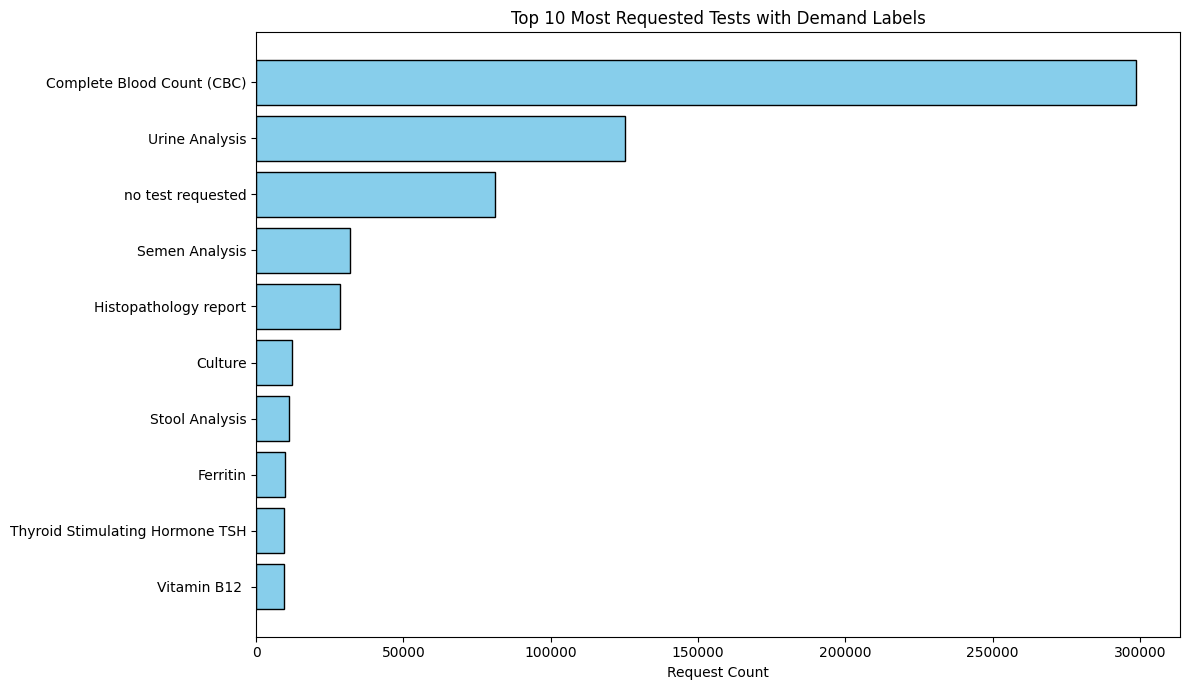

In [133]:
# visualizing top 10 requested tests by patients!
plt.figure(figsize = (12, 7))
bars = plt.barh(
    top10['req_tests'],
    top10['count'],
    color = 'skyblue',
    edgecolor = 'black'
)
plt.xlabel('Request Count')
plt.title('Top 10 Most Requested Tests with Demand Labels')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [134]:
# adding 'test_demand' col to our df
df3 = df3.join(
    labeled_tests.select('req_tests', 'test_demand'),
    on = 'req_tests',
    how = 'left'
)

In [135]:
df3.columns

['req_tests', 'regist_id', 'visit_date', 'test_name', 'results', 'test_demand']

In [136]:
df3.show()

+--------------------+---------+-------------------+--------------------+---------------+-----------+
|           req_tests|regist_id|         visit_date|           test_name|        results|test_demand|
+--------------------+---------+-------------------+--------------------+---------------+-----------+
|Thyroid Stimulati...|230513305|2023-11-22 12:39:31|Thyroid Stimulati...|     1.6 uIU/ml|       High|
|Thyroid Stimulati...|240512787|2024-10-05 12:34:13|Thyroid Stimulati...|     3.7 uIU/ml|       High|
|Thyroid Stimulati...| 23057626|2023-07-26 08:47:25|Thyroid Stimulati...|     3.5 uIU/ml|       High|
|             Calcium|  2506264|2025-02-24 11:36:38|             Calcium|    2.19 mmol/L|       High|
|Prostatic Specifi...| 24013706|2024-08-01 11:57:57|Prostatic Specifi...|      0.3 ng/ml|       High|
|Prostatic Specifi...| 24054553|2024-04-18 12:29:19|Prostatic Specifi...|      6.3 ng/ml|       High|
|Complete Blood Co...| 23018368|2023-12-20 11:22:28|    Hemoglobin Level|      10.

In [138]:
# and reordering cols again
df3 = df3.select(
    'regist_id',
    'visit_date',
    'req_tests',
    'test_name',
    'test_demand',
    'results'
)

In [139]:
df3.columns

['regist_id', 'visit_date', 'req_tests', 'test_name', 'test_demand', 'results']

#**Scenario 2 - Test Demand Trends Over Time**

In [149]:
df4 = df3.select('*')

In [150]:
# extracing to find trends
df4 = df4.withColumn('visit_day', to_date(col('visit_date')))
df4 = df4.withColumn('visit_year', year(col('visit_date')))
df4 = df4.withColumn('visit_month', month(col('visit_date')))
df4 = df4.withColumn('visit_week', weekofyear(col('visit_date')))
df4 = df4.withColumn('visit_dayofweek', dayofweek(col('visit_date')))

In [151]:
# count number of visits per year and month, ordered chronologically
monthly_trends = df4.groupBy('visit_year', 'visit_month') \
                    .count() \
                    .orderBy('visit_year', 'visit_month')

In [153]:
# turn into pandas to plot
monthly_trends_pd = monthly_trends.toPandas()

In [154]:
# create a formatted 'month' column like '2024-06' for plotting timelines
monthly_trends_pd['month'] = monthly_trends_pd['visit_year'].astype(str) + '-' + monthly_trends_pd['visit_month'].astype(str).str.zfill(2)

In [155]:
# formatting into datetime
monthly_trends_pd['month'] = pd.to_datetime(monthly_trends_pd['month'], format = '%Y-%m').dt.strftime('%Y-%m')

In [156]:
# viewing how it looks
print(monthly_trends_pd[['month']].head())

     month
0  2022-04
1  2022-05
2  2022-06
3  2022-07
4  2022-08


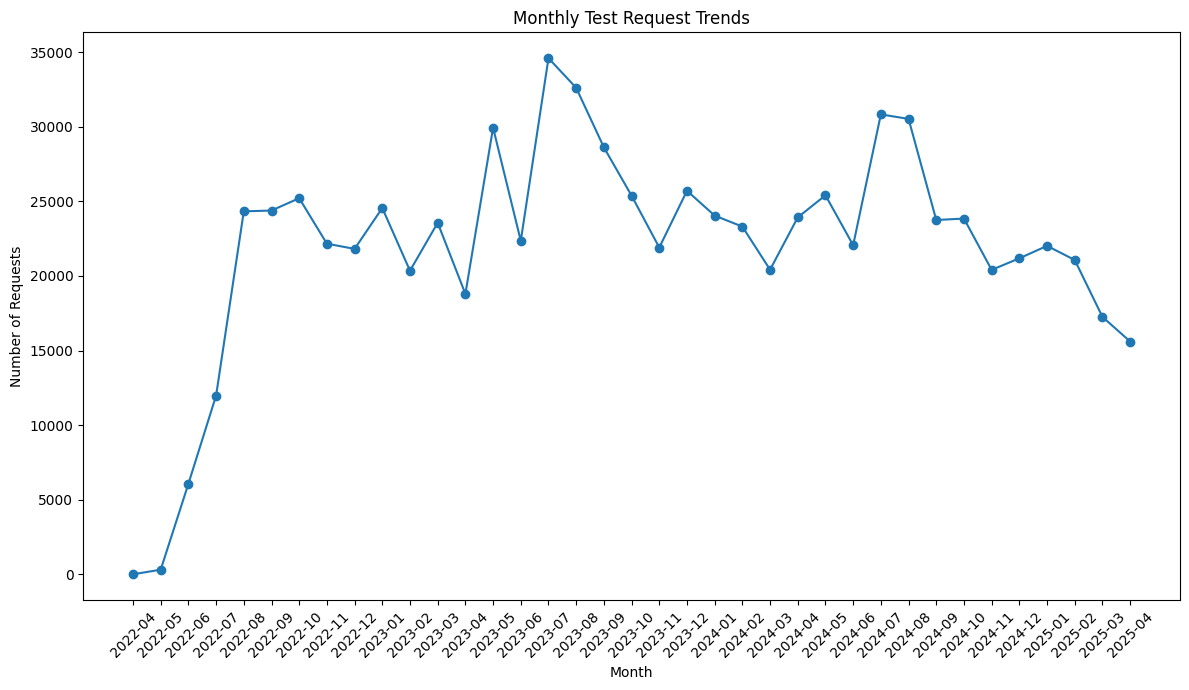

In [157]:
# plotting!
monthly_trends_pd = monthly_trends_pd.sort_values(by = 'month')

plt.figure(figsize = (12, 7))
plt.plot(monthly_trends_pd['month'], monthly_trends_pd['count'], marker = 'o')
plt.xticks(rotation = 45)
plt.title('Monthly Test Request Trends')
plt.xlabel('Month')
plt.ylabel('Number of Requests')
plt.tight_layout()
plt.show()

In [164]:
# create a numerical month index starting from 2022-01 as 1 for regression
# kinda like label encoder
modelingmonthly_trends = monthly_trends.withColumn(
    'month_index',
    (col('visit_year') - 2022) * 12 + col('visit_month')
)

In [165]:
# combine 'month_index' into a feature vector column for model input
assembler = VectorAssembler(inputCols = ['month_index'], outputCol = 'features')
data = assembler.transform(monthly_trends)

In [166]:
from pyspark.ml.regression import DecisionTreeRegressor
# using decision tree regressor to predict test counts per month!
dtr = DecisionTreeRegressor(featuresCol = 'features', labelCol = 'count')
model = dtr.fit(data)
predictions = model.transform(data)

In [167]:
predictions.select('visit_year', 'visit_month', 'count', 'prediction').show()

+----------+-----------+-----+----------+
|visit_year|visit_month|count|prediction|
+----------+-----------+-----+----------+
|      2022|          4|   11|      11.0|
|      2022|          5|  318|     318.0|
|      2022|          6| 6075|    6075.0|
|      2022|          7|11987|   18159.0|
|      2022|          8|24331|   18159.0|
|      2022|          9|24385|   23150.0|
|      2022|         10|25212|   23150.0|
|      2022|         11|22164|   23150.0|
|      2022|         12|21816|   23150.0|
|      2023|          1|24556|   23150.0|
|      2023|          2|20351|   23150.0|
|      2023|          3|23566|   23150.0|
|      2023|          4|18799|   18799.0|
|      2023|          5|29937|   26145.5|
|      2023|          6|22354|   26145.5|
|      2023|          7|34598|   33602.5|
|      2023|          8|32607|   33602.5|
|      2023|          9|28620|   24078.7|
|      2023|         10|25381|   24078.7|
|      2023|         11|21906|   24078.7|
+----------+-----------+-----+----

In [168]:
# into pandas to plot!
preds_pd = predictions.select('month_index', 'count', 'prediction').toPandas()
preds_pd = preds_pd.sort_values('month_index')

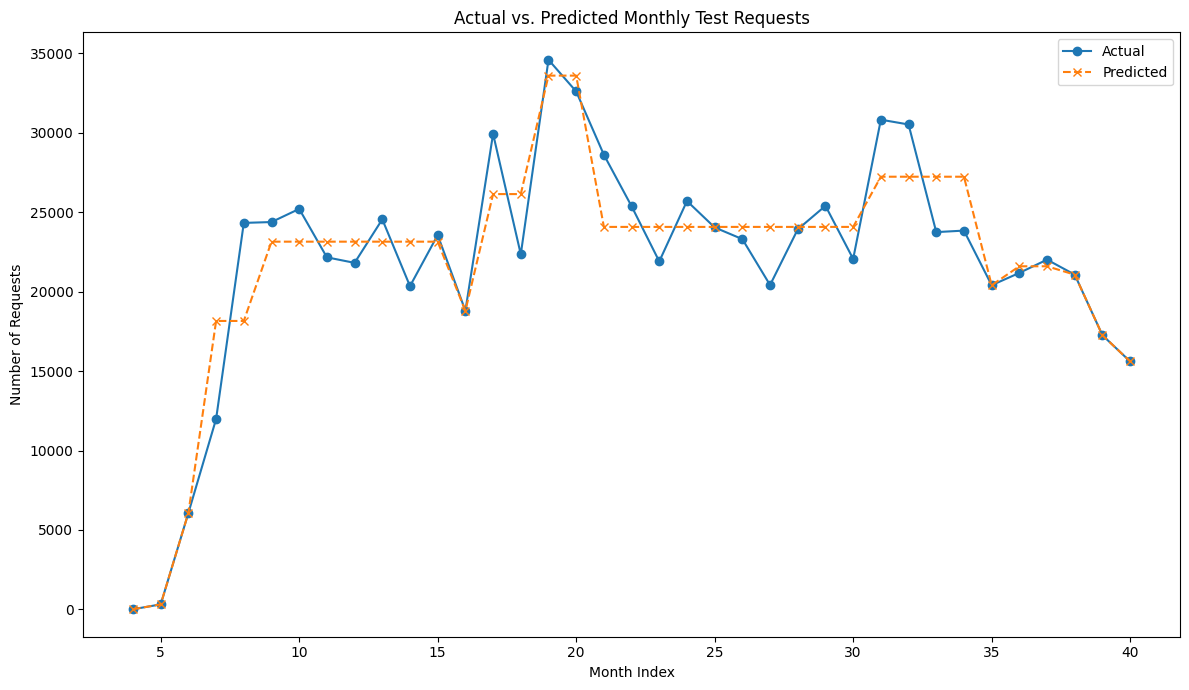

In [169]:
# plotting actual vs predicted!
plt.figure(figsize = (12, 7))
plt.plot(
    preds_pd['month_index'],
    preds_pd['count'],
    label = 'Actual',
    marker = 'o'
)
plt.plot(
    preds_pd['month_index'],
    preds_pd['prediction'],
    label = 'Predicted',
    linestyle = '--',
    marker = 'x'
)
plt.xlabel('Month Index')
plt.ylabel('Number of Requests')
plt.title('Actual vs. Predicted Monthly Test Requests')
plt.legend()
plt.tight_layout()
plt.show()

In [172]:
# add a 'season' column assigning each month to its season (winter, spring, summer, fall)
df4 = df4.withColumn(
    'season',
    when(col('visit_month').isin(12, 1, 2), 'Winter')
    .when(col('visit_month').isin(3, 4, 5), 'Spring')
    .when(col('visit_month').isin(6, 7, 8), 'Summer')
    .when(col('visit_month').isin(9, 10, 11), 'Fall')
)

In [173]:
df4.columns

['regist_id',
 'visit_date',
 'req_tests',
 'test_name',
 'test_demand',
 'results',
 'visit_day',
 'visit_year',
 'visit_month',
 'visit_week',
 'visit_dayofweek',
 'season']

In [174]:
season_counts = df4.groupBy('season').count().orderBy('season')

In [175]:
season_counts_pd = season_counts.toPandas()

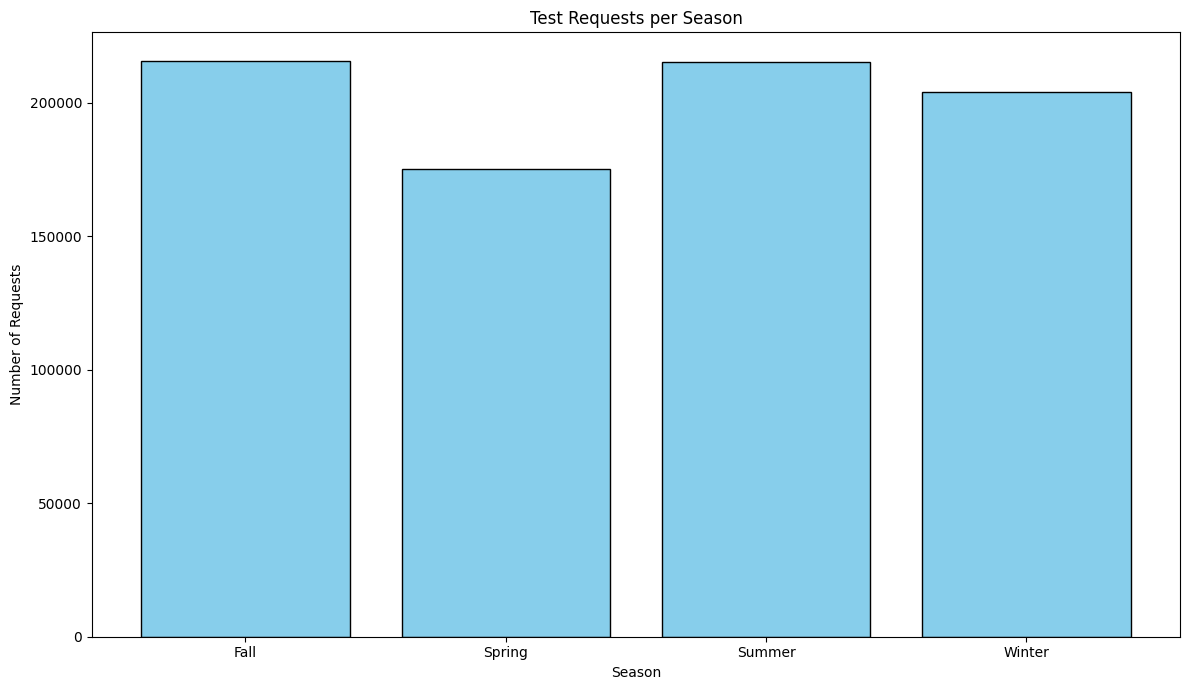

In [177]:
# plotting count of tests per season!
plt.figure(figsize = (12, 7))
plt.bar(season_counts_pd['season'],
        season_counts_pd['count'],
        color = 'skyblue',
        edgecolor = 'black')
plt.title('Test Requests per Season')
plt.xlabel('Season')
plt.ylabel('Number of Requests')
plt.tight_layout()
plt.show()

#**Saving Cleaned Data**

In [181]:
df4.columns

['regist_id',
 'visit_date',
 'req_tests',
 'test_name',
 'test_demand',
 'results',
 'visit_day',
 'visit_year',
 'visit_month',
 'visit_week',
 'visit_dayofweek',
 'season']

In [187]:
df4.coalesce(1).write.mode('overwrite').option('header', True).csv('consulting_labs_cleaned')

#**End of Code :)**